Different Word Embeddings on Text Classification

## Compared among word2vec, TF-IDF weighted

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from numpy import random
import gensim
import spacy
import nltk
import os
import pickle

import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter('ignore')
pd.set_option('max_colwidth',1000)


%matplotlib inline

# Abstract


* The post ["Text Classification with Word2vec"](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/) by nadbor demos how to write your own class to compute average word embedding for doc, either simple averaging or TF-IDF weighted one.

* ["Multi-Class Text Classification Model Comparison and Selection"](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568) by Susan Li teaches me how to write beautiful averaging function for word embedding.

* This tutorial ["Gensim Doc2vec Tutorial on the IMDB Sentiment Dataset"](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb) has step by step guidance on how to create doc2vec via Gensim.

* ["Distributed representations of sentences and documents"](https://blog.acolyer.org/2016/06/01/distributed-representations-of-sentences-and-documents/) by Le & Mikolov presents a clear and easy-to-understand explanation on what's going under doc2vec.

## Read in Dataset

In [4]:
# Read in file.
#dir_path = 'Private-Dataset'

#df = pd.read_csv(os.path.join(dir_path, 'consumer_complaints_simple.csv'))
#df = df[pd.notnull(df['consumer_complaint_narrative'])]

In [111]:
dir_path = 'dataset_family'
dataframe=pd.read_csv(os.path.join('dataset_family','KG_dataset_1_family_medicine.csv'))

In [100]:
dataframe

,subject,relation,object,subject_type,object_type
0,Family physicians,hold,M.D.,NOUN_CHUNK,NOUN_CHUNK
1,certification,requires,five years,NOUN_CHUNK,DATE
2,term Primary Care,include,services,NOUN_CHUNK,NOUN_CHUNK
3,Family physicians,deliver,range,NOUN_CHUNK,NOUN_CHUNK
4,family physicians,treat,patients,NOUN_CHUNK,NOUN_CHUNK
...,...,...,...,...,...
2302,the British Library,announced,support,ORG,NOUN_CHUNK
2303,process,reveal,errors,NOUN_CHUNK,NOUN_CHUNK
2304,publishers,provide,PDF,NOUN_CHUNK,NOUN_CHUNK
2305,system,provides,search capability,NOUN_CHUNK,NOUN_CHUNK


## Get Familiar with Dataset

In [195]:
# Get familiar with dataset.
df.shape

(2307, 100)

In [196]:
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.473629,-0.010914,1.050279,0.352412,-0.277018,-1.451229,1.331671,1.770982,-0.338017,-0.195359,...,-0.184007,1.859551,0.999463,0.467373,-0.213706,-0.590321,0.953257,0.333731,1.207831,1.627180
1,-0.233974,-0.341965,0.948033,0.513649,-0.699350,-0.722048,0.830728,1.412564,-0.011208,-0.352370,...,0.295179,1.569513,0.807874,-0.132492,-0.073900,-0.733517,0.221343,-0.341303,0.238347,0.821941
2,0.051266,-0.444998,1.339682,0.618300,-1.560235,-1.087665,1.368291,1.978701,0.232516,-0.660600,...,0.182463,1.896598,0.878900,-0.803817,-0.140205,-0.674451,0.249104,-0.649911,0.299851,1.529892
3,-0.473629,-0.010914,1.050279,0.352412,-0.277018,-1.451229,1.331671,1.770982,-0.338017,-0.195359,...,-0.184007,1.859551,0.999463,0.467373,-0.213706,-0.590321,0.953257,0.333731,1.207831,1.627180
4,-0.473629,-0.010914,1.050279,0.352412,-0.277018,-1.451229,1.331671,1.770982,-0.338017,-0.195359,...,-0.184007,1.859551,0.999463,0.467373,-0.213706,-0.590321,0.953257,0.333731,1.207831,1.627180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2302,-0.453789,-0.458845,1.118010,0.608971,-1.017564,-0.825280,0.982494,1.487655,0.017569,-0.232805,...,0.149137,2.195689,1.097760,-0.100429,-0.161448,-0.964938,0.276385,-0.214516,0.529631,0.928479
2303,-0.202098,-0.377732,0.893623,0.455154,-0.716895,-0.494365,0.673729,1.161318,0.004614,-0.277787,...,0.167257,1.304993,0.580277,-0.204544,-0.093876,-0.627803,0.119061,-0.293968,0.184690,0.777471
2304,-0.029437,-0.003328,-0.023781,-0.021610,0.023800,-0.021081,-0.020203,0.004720,0.033674,-0.031330,...,-0.018494,-0.010348,-0.023479,0.028877,0.015369,0.019048,0.007281,0.011240,0.008147,-0.022915
2305,-0.232057,-0.823913,1.310135,0.744719,-1.441924,-0.940458,1.083238,1.933908,0.200655,-0.564065,...,0.383059,2.372298,0.974579,-0.508563,-0.068426,-0.997131,0.112697,-0.582486,0.183347,1.200554


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2307 entries, 0 to 2306
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2307 non-null   float64
 1   1       2307 non-null   float64
 2   2       2307 non-null   float64
 3   3       2307 non-null   float64
 4   4       2307 non-null   float64
 5   5       2307 non-null   float64
 6   6       2307 non-null   float64
 7   7       2307 non-null   float64
 8   8       2307 non-null   float64
 9   9       2307 non-null   float64
 10  10      2307 non-null   float64
 11  11      2307 non-null   float64
 12  12      2307 non-null   float64
 13  13      2307 non-null   float64
 14  14      2307 non-null   float64
 15  15      2307 non-null   float64
 16  16      2307 non-null   float64
 17  17      2307 non-null   float64
 18  18      2307 non-null   float64
 19  19      2307 non-null   float64
 20  20      2307 non-null   float64
 21  21      2307 non-null   float64
 22 

In [7]:
#df.to_csv(os.path.join(dir_path, 'consumer_complaints_simple.csv'), index=False)

## Filter on Text and Label

In [8]:
# Filter on text and label.
#df = df[['product','consumer_complaint_narrative']]

In [101]:
dataframe=dataframe[['subject','object']]

In [102]:
dataframe

,subject,object
0,Family physicians,M.D.
1,certification,five years
2,term Primary Care,services
3,Family physicians,range
4,family physicians,patients
...,...,...
2302,the British Library,support
2303,process,errors
2304,publishers,PDF
2305,system,search capability


In [9]:
# Experiment on smaller subset.
#df = df[:25000]

In [104]:
df=dataframe
print(df)

                  subject             object
0       Family physicians               M.D.
1           certification         five years
2       term Primary Care           services
3       Family physicians              range
4       family physicians           patients
...                   ...                ...
2302  the British Library            support
2303              process             errors
2304           publishers                PDF
2305               system  search capability
2306     randomised trial           increase

[2307 rows x 2 columns]


<mark>**Chart of Label Frequency**</mark>

Now, let's see how frequency distributed among each label.

In [105]:
# Distribution of target variable.
display(df['object'].value_counts())

# df[['product', 'sub_product']].apply(lambda x: str(x[0]) + '///' + str(x[1]),
#                                      axis=1).value_counts()

place                        19
surgery                      16
number                       14
risk                          9
training                      8
                             ..
known account                 1
approximately 10 per cent     1
tens of thousands             1
the Paris Hospital            1
satisfaction                  1
Name: object, Length: 1924, dtype: int64

Frequency(Top 30)...


,freq,count
place,0.008236,19
surgery,0.006935,16
number,0.006068,14
risk,0.003901,9
training,0.003468,8
degree,0.003468,8
four years,0.003468,8
use,0.003468,8
range,0.003034,7
6 years,0.003034,7


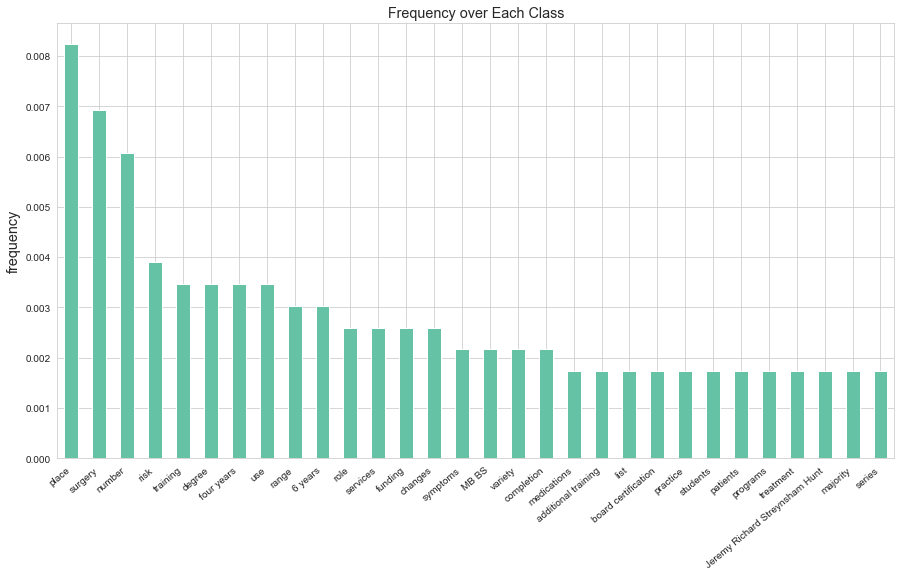

In [106]:
from UtilTextClassification import plot_freq

plot_freq(df, col=['object'], top_classes=30)

<mark>**Sample of Dataset**</mark>

Demo of (product, complaints) example to get a feeling of what complaints will be like to corresponding product.

In [107]:
print('Demo of product and its complaint example...')
df.head()

Demo of product and its complaint example...


,subject,object
0,Family physicians,M.D.
1,certification,five years
2,term Primary Care,services
3,Family physicians,range
4,family physicians,patients


# Document Preprocessing

Now comes the first step -Doc Preprocessing. Before we create our own word embedding based on the input texts, we need to preprocess the text so that it complies with the input format as Gensim requires. It involves multiple steps starting from word tokenization, bi-gram detection, lemmatization etc..

Here, I wrote a python class called **DocProcess**. This class implements all the nitty-gritty jobs mentioned above for us under the hood, such as:

1. First, the class takes in a series of texts, then tokenizes the text and removes all punctuations.

2. It has the option build_bi, meaning whether to build up bi-gram, function adopted from Gensim. The default is False, if option build_bi is set to True, then the class will train a bi-gram detector and create bi-gram words for the text.

3. Now, all the processed tokens are concatenated back to form a sentence again.

4. The texts are tokenized once again, but this time, both **stop words** and **parts of speech** that are not allowed in the text will be removed and all tokens are **lemmatized**. These tokens are stored as `self.doc_words` - list of the tokens for each text(doc).

5. Finally, these `self.doc_words` are wrapped up into **TaggedDocument**, a object type in Gensim for later use in doc2vec training. It's stored in `self.tagdocs`.

In [108]:
import spacy


nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [110]:
from UtilWordEmbedding import DocPreprocess



all_docs = DocPreprocess(nlp, stop_words, df['subject'], df['object'])

In [18]:
type(all_docs)

UtilWordEmbedding.DocPreprocess

In [112]:
import pickle


# Save all_docs as pickle.
with open(os.path.join(dir_path, 'all_docs.pickle'), 'wb') as f:
    pickle.dump(all_docs, f, pickle.HIGHEST_PROTOCOL)

In [113]:
import pickle


# Read pickle.
with open(os.path.join(dir_path, 'all_docs.pickle'), 'rb') as f:
    all_docs = pickle.load(f)

## Deomo - Structure of Preprocessed Docs

In [114]:
# Demo: structure of preprocessed docs.
type(all_docs)

UtilWordEmbedding.DocPreprocess

In [115]:
len(all_docs.tagdocs)

2307

In [116]:
print('Demo of tagged document...')
all_docs.tagdocs[4]

Demo of tagged document...


TaggedDocument(words=['family', 'physician'], tags=[4])

In [117]:
print('Demo of doc words...')
all_docs.doc_words[4][:10]

Demo of doc words...


['family', 'physician']

In [118]:
print('Label of tagged document...')
all_docs.labels.iloc[4]

Label of tagged document...


'patients'

# Build up Word Model - Word2vec

Since the text are properly processed, we're ready to train our word2vec via Gensim. Here I chose the dimension size 100 for each word embedding and window size of 5. The training iterates for 100 times.

In [119]:
import multiprocessing
import sys
from gensim.models.word2vec import Word2Vec

workers = multiprocessing.cpu_count()
print('number of cpu: {}'.format(workers))
assert gensim.models.word2vec.FAST_VERSION > -1, "This will be painfully slow otherwise."

number of cpu: 8


In [120]:
word_model = Word2Vec(all_docs.doc_words,
                      min_count=2,
                      size=100,
                      window=5,
                      workers=workers,
                      iter=100)

In [121]:
########testing the taggeed document function fromgensim


from gensim.models.doc2vec import TaggedDocument
s1 = 'the quick fo[hx6  brown fox jumps over the lazy dog'
s1_tag = '001'
s2 = 'i want to burn a zero-day'
s2_tag = '002'
m=[1]
words=s1.split()
doc_ids = np.arange(len(words))
print(doc_ids)
m.append(TaggedDocument(words=s1.split(), tags=[doc_ids]))
tags=[doc_ids]
print(tags)
print(m)

[0 1 2 3 4 5 6 7 8 9]
[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]
[1, TaggedDocument(words=['the', 'quick', 'fo[hx6', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog'], tags=[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])])]


In [122]:
doc_ids

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [123]:
tags=[s1_tag]
print(tags)

['001']


# Averaging Word Embedding for Each Doc

OK! Now we have the word embedding at hand, we'll be using the word embedding to compute for representative vector for whole text. It then serves as feature input for text classification model. There are various ways to come up with doc vector. First, let's start with the simple one.

## Simple Averaging on Word Embedding

This is a rather straightforward method. It directly averages all word embedding occurred in the text. Here I adapted the code from these two posts [2](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/), [3](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568) and created the python class **MeanWordEmbeddingVectorizer**.

In [124]:
from UtilWordEmbedding import MeanEmbeddingVectorizer


mean_vec_tr = MeanEmbeddingVectorizer(word_model)
doc_vec = mean_vec_tr.transform(all_docs.doc_words)

# print('Demo of word averaging doc vector...')
# display(doc_vec[4])

In [125]:
# Save word averaging doc2vec.
print('Shape of word-mean doc2vec...')
display(doc_vec.shape)
print('Save word-mean doc2vec as csv file...')
np.savetxt(os.path.join(dir_path,'doc_vec.csv'), doc_vec, delimiter=',')

Shape of word-mean doc2vec...


(2307, 100)

Save word-mean doc2vec as csv file...


## TF-IDF Weighted Averaging on Word Embedding

Not just satisfied with simple averaging? We can further adopt TF-IDF as weights for each word embedding. This will amplify the role of significant word in computing doc vector. Here, the whole process is implemented under class **TfidfEmbeddingVectorizer**. Again, the code is adapted from the same post source.

One thing worth noted is that, the Term Frequency has already been considered when we conduct averaging over the text, but not Inverse Document Frequency, thus the weight literally being the IDF, and the unseen word is assigned the max IDF in default setting.

And the other thing to note is that we need to fit the class with tokens first, for it must loop through all the words before hand in order to compute IDF.

In [164]:
from UtilWordEmbedding import TfidfEmbeddingVectorizer



tfidf_vec_tr = TfidfEmbeddingVectorizer(word_model)

In [165]:
tfidf_vec_tr.fit(all_docs.doc_words)  # fit tfidf model first
tfidf_doc_vec = tfidf_vec_tr.transform(all_docs.doc_words)


# print('Demo of tf-idf word averaging doc vector...')
# display(tfidf_doc_vec[4])

In [166]:
# Save tfidf word averaging doc2vec.
print('Shape of tfidf-word-mean doc2vec...')
display(tfidf_doc_vec.shape)
print('Save tfidf-word-mean doc2vec as csv file...')
np.savetxt(os.path.join(dir_path, 'tfidf_doc_vec.csv'), tfidf_doc_vec, delimiter=',')

Shape of tfidf-word-mean doc2vec...


(2307, 100)

Save tfidf-word-mean doc2vec as csv file...


## Apply Doc2vec Training Directly

### PV-DM Model

Last but not least, we still have one more option - to directly train doc2vec, and no need to average all word embeddings. Here I chose **PV-DM model** to train my doc2vec.

The script is mostly referred from [Gensim tutorial](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb). And again, to save all the labor, I create a class **DocModel** for it. The class just needs to take in the **TaggedDocument** and then we call `self.custom_train()` method, the doc model will train itself.

<mark>**APPENDIX: Training with Fixed Learning Rate.**</mark>

It's said to achieve better result, but the statement is from a rather old-version gensim tutorial. I found no better training result out of using fixed learning rate. Instead, using the default one, which is also recommended by the new gensim document achieving better performance.

Excerpted from [Doc2vec tutorial](https://rare-technologies.com/doc2vec-tutorial/)

I have obtained better results by iterating over the data several times and either

1. randomizing the order of input sentences, or
2. manually controlling the learning rate over the course of several iterations.

In [131]:
from UtilWordEmbedding import DocModel

# Configure keyed arguments for Doc2Vec model.
dm_args = {
    'dm': 1,
    'dm_mean': 1,
    'vector_size': 100,
    'window': 5,
    'negative': 5,
    'hs': 0,
    'min_count': 2,
    'sample': 0,
    'workers': workers,
    'alpha': 0.025,
    'min_alpha': 0.025,
    'epochs': 100,
    'comment': 'alpha=0.025'
}

In [132]:
# Instantiate a pv-dm model.
dm = DocModel(docs=all_docs.tagdocs, **dm_args)

In [133]:
dm.custom_train()

In [134]:
# Demo: doc vector.
# dm.model.docvecs[0]

In [135]:
# Save doc2vec as feature dataframe.
dm_doc_vec_ls = []
for i in range(len(dm.model.docvecs)):
    dm_doc_vec_ls.append(dm.model.docvecs[i])


dm_doc_vec = pd.DataFrame(dm_doc_vec_ls)
print('Shape of dm doc2vec...')
display(dm_doc_vec.shape)

print('Save dm doc2vec as csv file...')
dm_doc_vec.to_csv(os.path.join(dir_path, 'dm_doc_vec.csv'), index=False, header=False)

Shape of dm doc2vec...


(2307, 100)

Save dm doc2vec as csv file...


## Save Target Label

In [136]:
print('Shape of target labels...')
display(all_docs.labels.shape)
target_labels = all_docs.labels

print('Save target labels...')
target_labels.to_csv(os.path.join(dir_path, 'target_labels.csv'), index=False, header=True)

Shape of target labels...


(2307,)

Save target labels...


# Prepare the Classification Model

Now, we've prepared all the necessary ingredients - different types of features. Let's experiment to observe their effect on classification performance. Here, I'll use **basic logistic model** as the base model and feed in different kind of features created earlier. Hence, to compare their effectiveness.

In addition to compare effects of each word embedding averaging method, I also try to **concatenate word2vec and doc2vec** together, and see if it can boost up the performance even more.

I used TF-IDF weighted word embedding and PV-DM doc2vec together. The result shows that it increases the accuracy on training dataset (perhaps a sign of over-fitting?), but not so significant improvement on testing dataset compared using TF-IDF word2vec alone.

In [167]:
import os

# Read in saved files.
dir_path = 'dataset_family'

doc_vec = pd.read_csv(os.path.join(dir_path, 'doc_vec.csv'), header=None)
tfidf_doc_vec = pd.read_csv(os.path.join(dir_path, 'tfidf_doc_vec.csv'), header=None)
#glove_doc_vec = pd.read_csv(os.path.join(dir_path, 'glove_doc_vec.csv'), header=None)
dm_doc_vec = pd.read_csv(os.path.join(dir_path, 'dm_doc_vec.csv'), header=None)
target_labels = pd.read_csv(os.path.join(dir_path, 'target_labels.csv'), header=0)

## Set up Model

In [172]:
from sklearn.linear_model import LogisticRegression


# Classification via Logistic Model
logistic = LogisticRegression(random_state=1, multi_class='multinomial', solver='saga')
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10,max_depth=2, bootstrap=True, max_features='sqrt')

In [141]:
from sklearn.linear_model import SGDClassifier

# (Optional) Classification via stochastic gradient descent classifier.
sgd = SGDClassifier(loss='hinge',
                    penality='l2',
                    verbose=1,
                    random_state=1,
                    learning_rate='invscaling',
                    eta0=1)

TypeError: __init__() got an unexpected keyword argument 'penality'

## (Demo) Hyper-Parameters

In [173]:
model = logistic  # or choose sgd.
df = tfidf_doc_vec
concate = False
concat_df = dm_doc_vec

## Define Train Function

In [174]:
from UtilTextClassification import split_size
from sklearn.model_selection import train_test_split




def main(model, df, concate, concat_df):
    if concate:
        df = pd.concat([df, concat_df], axis=1, ignore_index=True)
    else:
        df = df

    # Specify train/valid/test size.
    train_size, valid_size, test_size = split_size(df, train=0.7, valid=0)  # no need to use valid dataset here
    # Prepare test dataset.
    train_X, test_X, train_y, test_y = train_test_split(df,
                                                    target_labels,
                                                    test_size=test_size,
                                                    random_state=1)

    # Prepare valid dataset.
    if valid_size != 0:
        train_X, valid_X, train_y, valid_y = train_test_split(train_X,
                                                      train_y,
                                                      test_size=valid_size,
                                                      random_state=1,
                                                      stratify=train_y)
    
    print('Shape of train_X: {}'.format(train_X.shape))
    print('Shape of valid_X: {}'.format(valid_X.shape if 'valid_X' in vars() else (0,0)))
    print('Shape of text_X: {}'.format(test_X.shape))
    
    model.fit(train_X, train_y)
    
    if valid_size != 0:
        return model, train_X, valid_X, test_X, train_y, valid_y, test_y
    else:
        return model, train_X, None, test_X, train_y, None, test_y

# Test Model

## Performance on Simple Averaging Word Vector

### Hyper-Parameters

In [187]:
model = clf  # or choose sgd.
df = doc_vec
concate = False
concat_df = dm_doc_vec

### Train

In [188]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (1614, 100)
Shape of valid_X: (0, 0)
Shape of text_X: (693, 100)


### Test on Training Dataset

In [189]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of Mean Word Vector on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of Mean Word Vector on training dataset...
Score on dataset...

Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Classification Report:
                                                                                                               precision    recall  f1-score   support

                                                                                                        $25M       0.33      1.00      0.50         1
                                                                                                 $54 million       0.00      0.00      0.00         1
                                                                                        1,347,900 passengers       0.00      0.00      0.00         1
                                                                                       1,704,694 inhabitants       0.00      0.00      0.00         1
         

### Test on Testing Dataset

In [190]:
# Score on test dataset.
print('Performance of Mean Word Vector on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of Mean Word Vector on testing dataset...
Score on dataset...

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Classification Report:
                                                                   precision    recall  f1-score   support

                                                     $16 billion       0.00      0.00      0.00         1
                                                            $25M       0.00      0.00      0.00         0
                                                         0 or 11       0.00      0.00      0.00         1
                                                    1,000 copies       0.00      0.00      0.00         1
                          1.6 billion LEED redevelopment project       0.00      0.00      0.00         1
                                                             11%       0.00      0.00      0.00         1
                  

## Performance on Tf-Idf Weighted Averaging Word Vector

### Hyper-Parameters

In [191]:
model = clf  # or choose sgd.
df = tfidf_doc_vec
concate = False
concat_df = dm_doc_vec

### Train

In [192]:
# __main__
clf, train_X, valid_X, test_X, train_y, valid_y, test_y = main(model, 
                                                               df, 
                                                               concate=concate, 
                                                               concat_df=concat_df)

Shape of train_X: (1614, 100)
Shape of valid_X: (0, 0)
Shape of text_X: (693, 100)


### Test on Training Dataset

In [193]:
from UtilTextClassification import sk_evaluate


# Score on valid dataset.
print('Performance of Tf-Idf Mean Word Vector on training dataset...')
_, _ = sk_evaluate(clf, train_X, train_y, label_names=None)

Performance of Tf-Idf Mean Word Vector on training dataset...
Score on dataset...

Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Classification Report:
                                                                                                               precision    recall  f1-score   support

                                                                                                        $25M       0.33      1.00      0.50         1
                                                                                                 $54 million       0.00      0.00      0.00         1
                                                                                        1,347,900 passengers       0.00      0.00      0.00         1
                                                                                       1,704,694 inhabitants       0.00      0.00      0.00         1
  

### Test on Testing Dataset

In [194]:
# Score on test dataset.
print('Performance of Tf-Idf Mean Word Vector on testing dataset...')
_, _ = sk_evaluate(clf, test_X, test_y, label_names=None)

Performance of Tf-Idf Mean Word Vector on testing dataset...
Score on dataset...

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Classification Report:
                                                                   precision    recall  f1-score   support

                                                     $16 billion       0.00      0.00      0.00         1
                                                            $25M       0.00      0.00      0.00         0
                                                         0 or 11       0.00      0.00      0.00         1
                                                    1,000 copies       0.00      0.00      0.00         1
                          1.6 billion LEED redevelopment project       0.00      0.00      0.00         1
                                                             11%       0.25      1.00      0.40         1
           